In [1]:
import bcolz
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

from mydatools import img_plot

%matplotlib inline

Using Theano backend.
Using cuDNN version 5103 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


In [2]:
path = 'data/input/all/'
# path = 'data/input/sample/'

In [3]:
def get_batches(dirname, gen=ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, target_size=target_size)
    # 这里shuffle不能为True 否则X,y不对应
    X = np.concatenate([batches.next()[0] for i in range(batches.samples)])
    y = np.concatenate([batches.next()[1] for i in range(batches.samples)])
    return X, y

def get_class(a_onehot):
    return a_onehot.argmax(axis=1)

## VGG16 finetune

删除一些层 重新进行训练

注意：只用重新训练后面几层，前面的卷积层带有图片的一些基础形状的识别

目标图片越接近vgg的图片分类，训练的层数可以少

而如果目标图片越不接近vgg的图片分类，可以多训练几层，甚至卷积层

In [4]:
train_batch_size = 40

In [5]:
X_tra, y_tra = get_data(path+'train')
X_val, y_val = get_data(path+'val')

y_tra_class = get_class(y_tra)
y_val_class = get_class(y_val)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


* 第一阶段训练

基于VGG16 将最后一层改为输出2个节点 并训练最后一层（仅训练最后一层）

In [60]:
# vgg16
base_model = VGG16()
conv_model = Model(base_model.input, base_model.layers[-4].output)

In [61]:
# fully connection model
fc_model = Sequential([
    Dense(4096, activation='relu', input_shape=conv_model.output_shape[-1:]),
    BatchNormalization(), # 感觉加入后 loss下降更快
    Dropout(0.5), 
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax'),
])

In [62]:
opt = RMSprop(lr=1e-5)
fc_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
# conv_tra = conv_model.predict(X_tra)
# conv_val = conv_model.predict(X_val)

In [64]:
# bcolz.carray(conv_tra, rootdir='data/output/temp/conv_tra.bc', mode='w')
# bcolz.carray(conv_val, rootdir='data/output/temp/conv_val.bc', mode='w')

In [65]:
conv_tra = bcolz.open('data/output/temp/conv_tra.bc')[:]
conv_val = bcolz.open('data/output/temp/conv_val.bc')[:]

In [66]:
fc_model.fit(conv_tra, y_tra, batch_size=train_batch_size, epochs=20, validation_data=(conv_val, y_val))

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 30s - loss: 0.2215 - acc: 0.9180 - val_loss: 0.1364 - val_acc: 0.9480
Epoch 2/20
22500/22500 [==============================] - 30s - loss: 0.1092 - acc: 0.9619 - val_loss: 0.0729 - val_acc: 0.9712
Epoch 3/20
22500/22500 [==============================] - 30s - loss: 0.0757 - acc: 0.9730 - val_loss: 0.0735 - val_acc: 0.9728
Epoch 4/20
22500/22500 [==============================] - 30s - loss: 0.0521 - acc: 0.9807 - val_loss: 0.0847 - val_acc: 0.9708
Epoch 5/20
22500/22500 [==============================] - 30s - loss: 0.0464 - acc: 0.9838 - val_loss: 0.1165 - val_acc: 0.9608
Epoch 6/20
22500/22500 [==============================] - 30s - loss: 0.0281 - acc: 0.9901 - val_loss: 0.0824 - val_acc: 0.9740
Epoch 7/20
22500/22500 [==============================] - 30s - loss: 0.0241 - acc: 0.9921 - val_loss: 0.1060 - val_acc: 0.9700
Epoch 8/20
22500/22500 [==============================]

In [40]:
fc_model.save_weights('data/output/temp/fc_weights.h5') # epochs=20

In [43]:
fc_model.load_weights('data/output/temp/fc_weights.h5')

## View prediction result

In [67]:
pred_proba = fc_model.predict(conv_val)
pred_class = get_class(pred_proba)

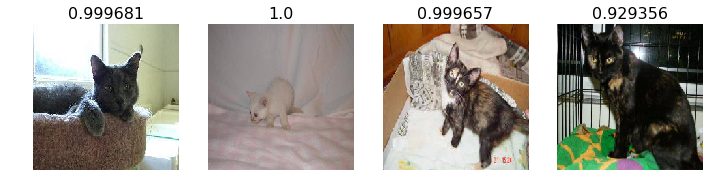

In [68]:
# 1. 展示正确的结果
cond = y_val_class == pred_class
show_imgs = X_val[cond][:4]
show_imgs_label = pred_proba[cond][:, 0][:4]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

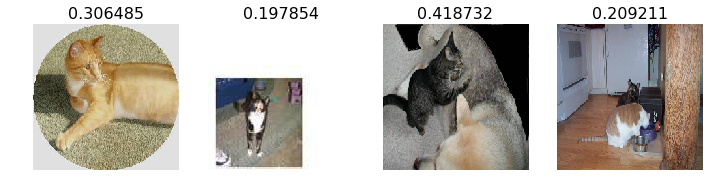

In [69]:
# 2. 展示错误的结果
cond = y_val_class != pred_class
show_imgs = X_val[cond][:4]
show_imgs_label = pred_proba[cond][:, 0][:4]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

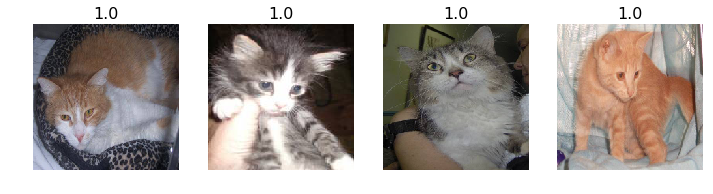

In [70]:
# 3. 展示最正确的结果
# 猫
class_id = 0
cond = (y_val_class == class_id) & (y_val_class == pred_class)
idx = pred_proba[cond][:, class_id].argsort()[::-1][:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

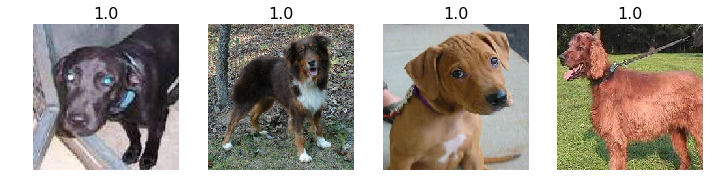

In [71]:
# 狗
class_id = 1
cond = (y_val_class == class_id) & (y_val_class == pred_class)
idx = pred_proba[cond][:, class_id].argsort()[::-1][:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

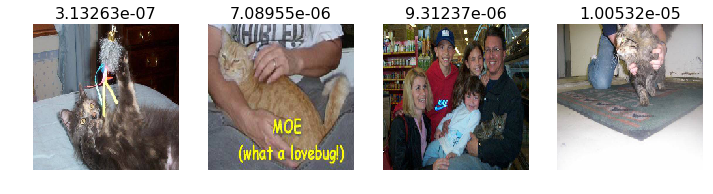

In [72]:
# 4. 展示最错误的结果
# 猫
class_id = 0
cond = (y_val_class == class_id) & (y_val_class != pred_class)
idx = pred_proba[cond][:, class_id].argsort()[:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

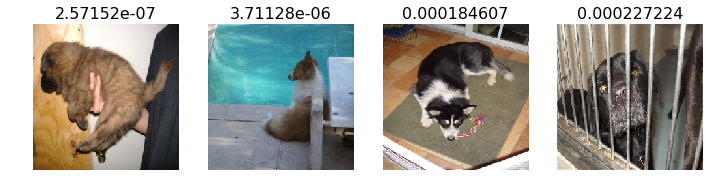

In [73]:
# 狗
class_id = 1
cond = (y_val_class == class_id) & (y_val_class != pred_class)
idx = pred_proba[cond][:, class_id].argsort()[:4]
show_imgs = X_val[cond][idx]
show_imgs_label = pred_proba[cond][idx][:, class_id]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

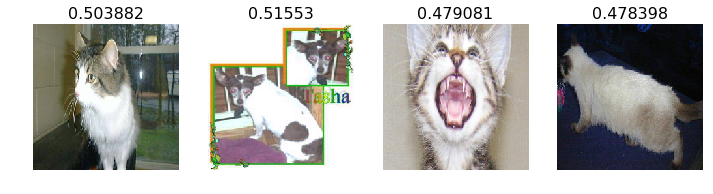

In [74]:
# 5. 最不确定的结果
idx = np.abs(pred_proba[:, 0] - 0.5).argsort()[:4]
show_imgs = X_val[idx]
show_imgs_label = pred_proba[idx][:, 0]
img_plot.img_plots(show_imgs, titles=show_imgs_label)

## 预测

In [75]:
test_batches = get_batches(path+'test', shuffle=False, batch_size=1, class_mode=None)

Found 12500 images belonging to 1 classes.


In [76]:
# conv_test = conv_model.predict_generator(test_batches, test_batches.samples)

In [77]:
# bcolz.carray(conv_test, rootdir='data/output/temp/conv_test.bc', mode='w')

In [78]:
conv_test = bcolz.open('data/output/temp/conv_test.bc')

In [79]:
test_prob = fc_model.predict(conv_test)

In [80]:
res_df = pd.DataFrame({
    'id': [f[8:-4] for f in test_batches.filenames],
#     'label': test_prob[:, tra_batches.class_indices['dog']],
    'label': test_prob[:, 1],
})
res_file_path = './data/output/vgg16_finetune.csv'

# 将label限制在0.05~0.95
clip_value = 0.025
res_df['label'] = res_df['label'].values.clip(min=clip_value, max=1-clip_value)

res_df.to_csv(res_file_path, index=False)

In [81]:
from IPython.display import FileLink
FileLink(res_file_path)

/home/ubuntu/nbs/MyKaggle/dogs-vs-cats-redux-kernels-edition/data/output/vgg16_finetune.csv

In [82]:
res_df['id'] = res_df['id'].apply(np.int)
res_df.sort_values('id')

,id,label
11689,1,0.975000
9656,2,0.975000
3737,3,0.975000
9068,4,0.975000
3868,5,0.025000
413,6,0.025000
7669,7,0.025000
1952,8,0.025000
11818,9,0.025000
7773,10,0.025000
